In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=7
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
# needs treshold  3 QuatreCamins, 2 SantBoi,  7 Mollet 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  4929.808641975347
Friday area:  4763.91666666666
Weekend area:  1473.9833333333395
Weekday maximum:  205.07407407407408
Friday maximum:  198.16666666666666
Weekend maximum:  65.1


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

#parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})


with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
         errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()





In [5]:
optimal_params_weekdayth=np.mean(optimal_params_weekdaytn.x[4:])

In [6]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24



In [7]:
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
prototype_math_arr_weekday=cdf1_wd.copy()

ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdayth)
t_parking_full=np.interp(optimal_params_weekdayth,cdf1_wd,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)

tn1_wd_unmodifed=tn1_wd
tn1_wd=np.insert(tn1_wd,ix_parking_full,np.interp(t_parking_full,time2,tn1_wd))
tn1_wd_excees=tn1_wd.copy()
tn1_wd[ix_parking_full+1:] =0
tn1_wd_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_wd), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_wd), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_wd[cdf1_wd>optimal_params_weekdayth] = optimal_params_weekdayth
cdf1_wd_plot=np.insert(cdf1_wd,ix_parking_full,optimal_params_weekdayth)

cdf1_wd = cdf1_wd/optimal_params_weekdayth
cdf1_wd_plot = cdf1_wd_plot/optimal_params_weekdayth

cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
cdf2_wd_plot=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))
prototype_math_dep_weekday=cdf2_wd


resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
resta_wd_plot = np.array(cdf1_wd_plot) - np.array(cdf2_wd_plot)
prototype_math_weekday = resta_wd
prototype_math_weekday_plot = resta_wd_plot

### FRIDAYS

In [8]:
optimal_params_fridayth=np.mean(optimal_params_fridaytn.x[4:])

In [9]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
prototype_math_arr_friday=cdf1_fri.copy()

ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridayth)
t_parking_full=np.interp(optimal_params_fridayth,cdf1_fri,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)


tn1_fri_unmodifed=tn1_fri
tn1_fri=np.insert(tn1_fri,ix_parking_full,np.interp(t_parking_full,time2,tn1_fri))
tn1_fri_excees=tn1_fri.copy()
tn1_fri[ix_parking_full+1:] =0
tn1_fri_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_fri), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_fri), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_fri[cdf1_fri>optimal_params_fridayth] = optimal_params_fridayth
cdf1_fri_plot=np.insert(cdf1_fri,ix_parking_full,optimal_params_fridayth)

cdf1_fri = cdf1_fri/optimal_params_fridayth
cdf1_fri_plot = cdf1_fri_plot/optimal_params_fridayth

cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])
cdf2_fri_plot=np.insert(cdf2_fri,ix_parking_full,np.interp(t_parking_full,time2,cdf2_fri))
prototype_math_dep_friday=cdf2_fri


resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
resta_fri_plot = np.array(cdf1_fri_plot) - np.array(cdf2_fri_plot)
prototype_math_friday = resta_fri
prototype_math_friday_plot = resta_fri_plot


### WEEKENDS

In [10]:
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])

cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we

In [11]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

tn_arr_weekday_n = prototype_math_arr_weekday
tn_dep_weekday_n = prototype_math_dep_weekday
tn_arr_friday_n = prototype_math_arr_friday
tn_dep_friday_n = prototype_math_dep_friday

### Denormalization / Rescaling

In [12]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_max + weekday_offset
tn_arr_weekday = tn_arr_weekday_n*weekday_max + weekday_offset

tn_weekday_nooff = tn_weekday_n*weekday_max 
tn_arr_weekday_nooff = tn_arr_weekday_n*weekday_max 
tn_dep_weekday = tn_dep_weekday_n*weekday_max #+ weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_max + friday_offset
tn_arr_friday = tn_arr_friday_n*friday_max + friday_offset

tn_friday_nooff = tn_friday_n*friday_max
tn_arr_friday_nooff = tn_arr_friday_n*friday_max
tn_dep_friday = tn_dep_friday_n*friday_max #+ friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_max + weekend_offset 

tn1_weekend_nooff = tn1_weekend_n*weekend_max 

In [13]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [14]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

## Running  Prediction

In [15]:
starting_hour=7
ending_hour=15

In [16]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

tn_arr_proto_dict={}
tn_arr_proto_dict["Monday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Tuesday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Wednesday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Thursday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Friday"] = tn_arr_friday_nooff


tn_dep_proto_dict={}
tn_dep_proto_dict["Monday"] = tn_dep_weekday
tn_dep_proto_dict["Tuesday"] = tn_dep_weekday
tn_dep_proto_dict["Wednesday"] = tn_dep_weekday
tn_dep_proto_dict["Thursday"] = tn_dep_weekday
tn_dep_proto_dict["Friday"] = tn_dep_friday


t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

proto_running_errorNOW_wd=[None] * len(predWindow_vec)
tn_running_errorNOW_wdTH=[None] *  len(predWindow_vec)
proto_running_errorNOW_fr=[None] * len(predWindow_vec)
tn_running_errorNOW_frTH=[None] * len(predWindow_vec)
proto_running_errorNOW_we=[None] * len(predWindow_vec)
tn_running_errorNOW_weTH=[None] * len(predWindow_vec)


for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        if day not in ['Saturday','Sunday']:
            
            tn_arr_proto = tn_arr_proto_dict[day]
            tn_dep_proto = tn_dep_proto_dict[day]
            [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNowTHv2(t_days,hist_proto,
                                                                            tn_arr_proto,tn_dep_proto,max_value,
                                                                            starting_hour,pred_window,ending_hour)
        else:
            [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                                              tn_proto,max_value,starting_hour,
                                                                              pred_window,ending_hour)
        
        if day=='Monday':
            proto_running_errorNOW_wd[j]=proto_running_error_vec_now
            tn_running_errorNOW_wdTH[j]=tn_running_error_vec_now
        elif day in ['Tuesday','Wednesday','Thursday']:
            proto_running_errorNOW_wd[j]=np.concatenate((proto_running_errorNOW_wd[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_wdTH[j]=np.concatenate((tn_running_errorNOW_wdTH[j], tn_running_error_vec_now), axis=1)
        elif day == 'Friday':
            proto_running_errorNOW_fr[j]=proto_running_error_vec_now
            tn_running_errorNOW_frTH[j]=tn_running_error_vec_now
        elif day == 'Saturday':
            proto_running_errorNOW_we[j]=proto_running_error_vec_now
            tn_running_errorNOW_weTH[j]=tn_running_error_vec_now
        else:
            proto_running_errorNOW_we[j]=np.concatenate((proto_running_errorNOW_we[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_weTH[j]=np.concatenate((tn_running_errorNOW_weTH[j], tn_running_error_vec_now), axis=1)
        
        
        
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

In [17]:
tn_running_error_wdTH=tn_running_errorNOW_wdTH[0]
tn_running_error_frTH=tn_running_errorNOW_frTH[0]
tn_running_error_weTH=tn_running_errorNOW_weTH[0]
proto_running_error_wd=proto_running_errorNOW_wd[0]
proto_running_error_fr=proto_running_errorNOW_fr[0]
proto_running_error_we=proto_running_errorNOW_we[0]

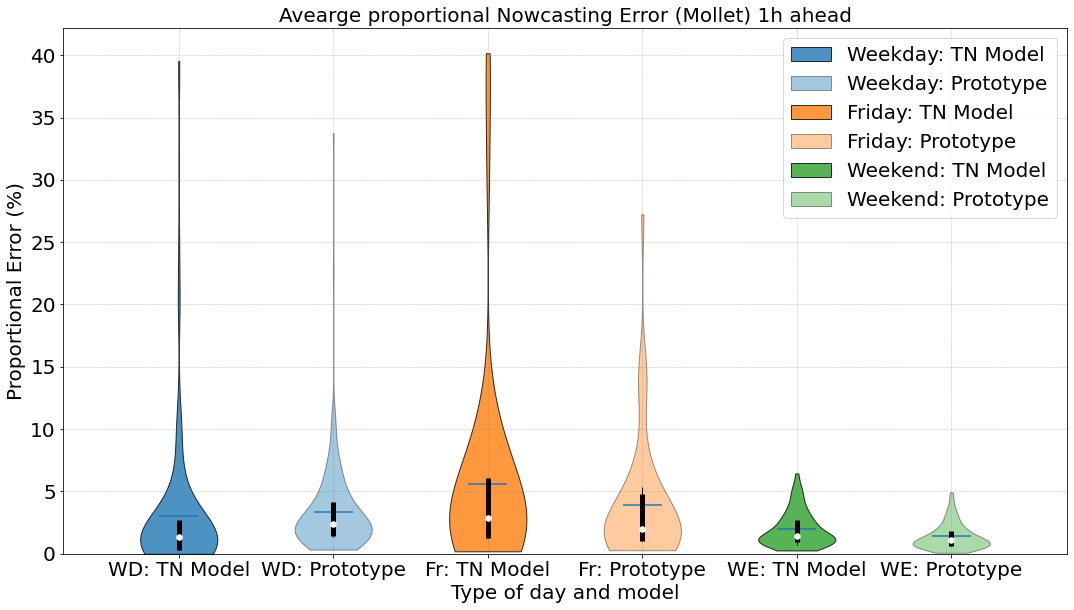

In [18]:
data = [tn_running_error_wdTH.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_frTH.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_weTH.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
fsize=20
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Nowcasting Error ("+ current_parking+') 1h ahead', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wdTH.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_frTH.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_weTH.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
#fig.savefig('RunningPredictionError_'+current_parking+'_violin_NOW1h_TH_till'+ending_hour +'h.pdf',bbox_inches='tight');

## Model without treshold

In [19]:
with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
         errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
    f.close()

In [20]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])


resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

In [21]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])


cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)

In [22]:
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])


cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])


resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)

In [23]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

In [24]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset
#**************************************WEEKDAY************************************
tn_weekday_nooff = tn_weekday_n*weekday_area
#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset
tn_friday_nooff = tn_friday_n*friday_area 
#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 
tn1_weekend_nooff = tn1_weekend_n*weekend_area

In [25]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

proto_running_errorNOW_wd=[None] * len(predWindow_vec)
tn_running_errorNOW_wd=[None] *  len(predWindow_vec)
proto_running_errorNOW_fr=[None] * len(predWindow_vec)
tn_running_errorNOW_fr=[None] * len(predWindow_vec)
proto_running_errorNOW_we=[None] * len(predWindow_vec)
tn_running_errorNOW_we=[None] * len(predWindow_vec)



for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                            tn_proto,max_value,starting_hour,pred_window,ending_hour)
        if day=='Monday':
            proto_running_errorNOW_wd[j]=proto_running_error_vec_now
            tn_running_errorNOW_wd[j]=tn_running_error_vec_now
        elif day in ['Tuesday','Wednesday','Thursday']:
            proto_running_errorNOW_wd[j]=np.concatenate((proto_running_errorNOW_wd[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_wd[j]=np.concatenate((tn_running_errorNOW_wd[j], tn_running_error_vec_now), axis=1)
        elif day == 'Friday':
            proto_running_errorNOW_fr[j]=proto_running_error_vec_now
            tn_running_errorNOW_fr[j]=tn_running_error_vec_now
        elif day == 'Saturday':
            proto_running_errorNOW_we[j]=proto_running_error_vec_now
            tn_running_errorNOW_we[j]=tn_running_error_vec_now
        else:
            proto_running_errorNOW_we[j]=np.concatenate((proto_running_errorNOW_we[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_we[j]=np.concatenate((tn_running_errorNOW_we[j], tn_running_error_vec_now), axis=1)
            
            
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

In [26]:
tn_running_error_wd=tn_running_errorNOW_wd[0]
tn_running_error_fr=tn_running_errorNOW_fr[0]
tn_running_error_we=tn_running_errorNOW_we[0]
proto_running_error_wd=proto_running_errorNOW_wd[0]
proto_running_error_fr=proto_running_errorNOW_fr[0]
proto_running_error_we=proto_running_errorNOW_we[0]

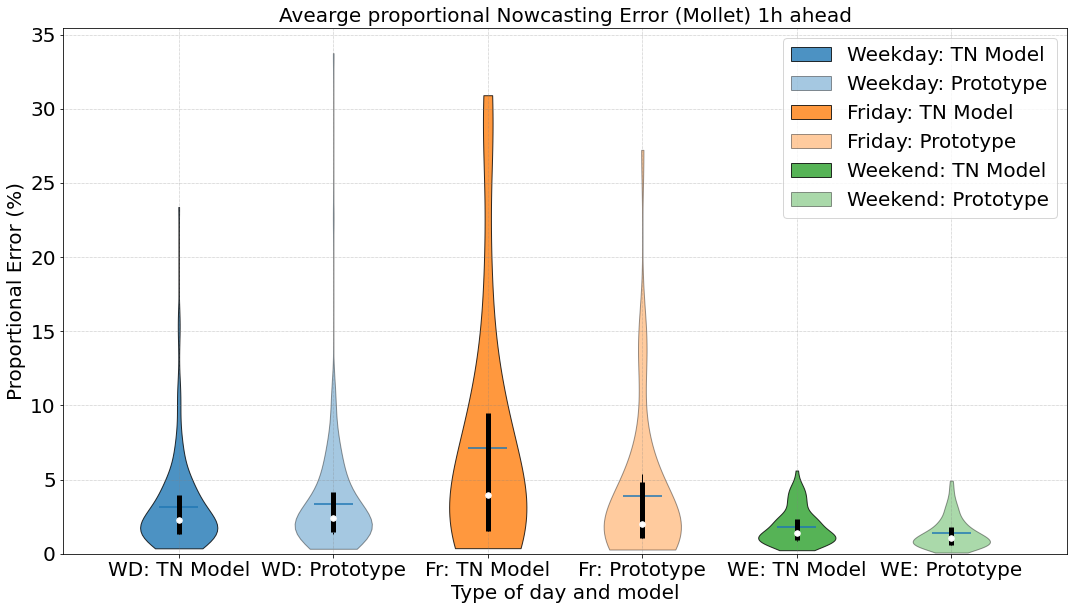

In [27]:
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_we.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Nowcasting Error ("+ current_parking+') 1h ahead', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
#fig.savefig('RunningPredictionError_'+current_parking+'_violin_NOW1h_till'+ending_hour +'h.pdf,bbox_inches='tight');

[2.29 1.32 2.38 3.96 2.88 2.03]


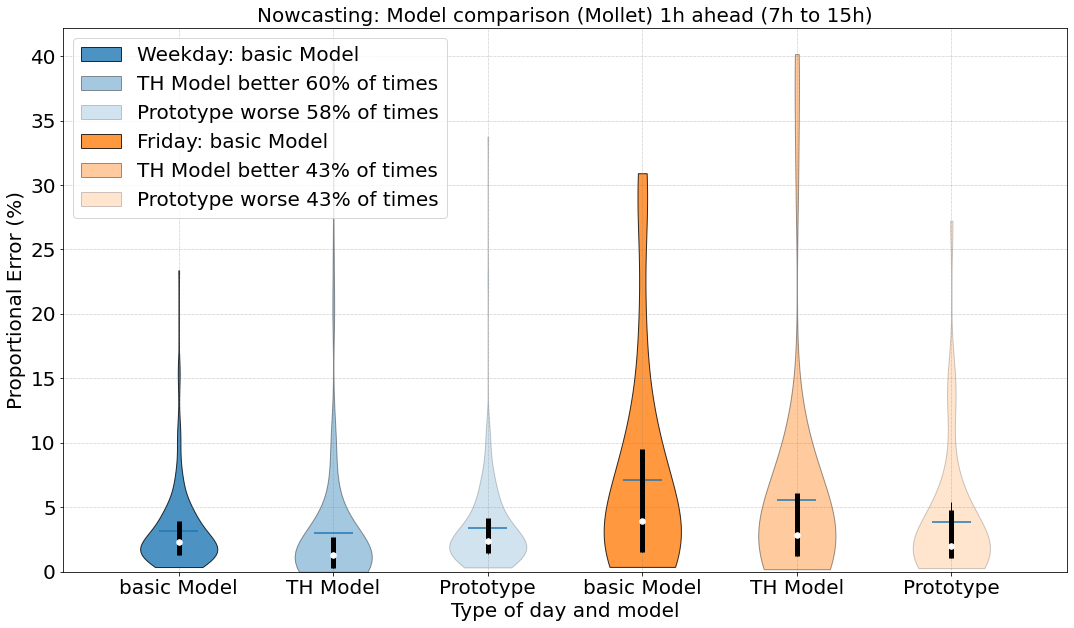

In [28]:
data = [tn_running_error_wd.flatten(),tn_running_error_wdTH.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),tn_running_error_frTH.flatten(),proto_running_error_fr.flatten()]
#,tn_running_error_we.flatten(),tn_running_error_weTH.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Nowcasting: Model comparison ("+ current_parking+') 1h ahead ('+str(starting_hour)
              + 'h to '+ str(ending_hour) +'h)', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%3==1:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.8)
    elif cc%3==2:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.4)   
    else:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.2)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),tn_running_error_wdTH.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),tn_running_error_frTH.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
#quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),tn_running_error_weTH.flatten()], [25, 50, 75], axis=1)

#quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
#medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
#quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)

quartile1=np.concatenate((quartile1wd, quartile1fr), axis=0)
medians=np.concatenate((medianswd, mediansfr), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr), axis=0)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


np.set_printoptions(precision=2)
print(medians)



propTHbetter_wd=sum(tn_running_error_wd.flatten()>tn_running_error_wdTH.flatten())/len(tn_running_error_wd.flatten())
propTHbetter_fr=sum(tn_running_error_fr.flatten()>tn_running_error_frTH.flatten())/len(tn_running_error_fr.flatten())
propworseTH_wd=sum(proto_running_error_wd.flatten()>tn_running_error_wdTH.flatten())/len(tn_running_error_wd.flatten())
propworseTH_fr=sum(proto_running_error_fr.flatten()>tn_running_error_frTH.flatten())/len(tn_running_error_fr.flatten())


# set style for the axes
labels = ['basic Model', 'TH Model','Prototype','basic Model', 'TH Model','Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

#ax2.legend(['Weekday: basic Model','Weekday: TH Model','Friday: basic Model','Friday: TH Model',
#           'Weekend: basic Model','Weekend: basic Model'], fontsize=fsize)

ax2.legend(['Weekday: basic Model','TH Model better ' +str(int(propTHbetter_wd*100)) +'% of times',
            'Prototype worse ' +str(int(propworseTH_wd*100)) +'% of times',
            'Friday: basic Model','TH Model better '+str(int(propTHbetter_fr*100)) +'% of times',
            'Prototype worse ' +str(int(propworseTH_fr*100)) +'% of times'], fontsize=fsize, loc='upper left')
#ax2.tick_params(axis='y', labelsize=20)
#plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('CompareRunningPredictionError_'+current_parking+'_violin_NOW1h_till'+str(ending_hour) +'hv2.pdf',bbox_inches='tight');

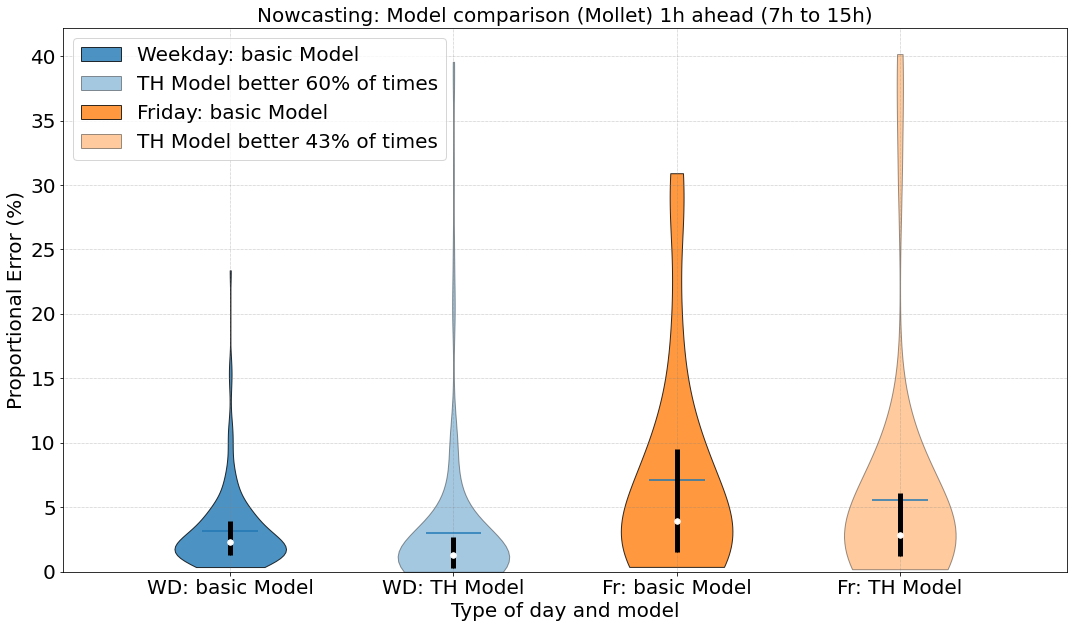

In [29]:
data = [tn_running_error_wd.flatten(),tn_running_error_wdTH.flatten(),
        tn_running_error_fr.flatten(),tn_running_error_frTH.flatten()]
#,tn_running_error_we.flatten(),tn_running_error_weTH.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Nowcasting: Model comparison ("+ current_parking+') 1h ahead ('+str(starting_hour)
              + 'h to '+ str(ending_hour) +'h)', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),tn_running_error_wdTH.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),tn_running_error_frTH.flatten()], [25, 50, 75], axis=1)
#quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),tn_running_error_weTH.flatten()], [25, 50, 75], axis=1)

#quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
#medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
#quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)

quartile1=np.concatenate((quartile1wd, quartile1fr), axis=0)
medians=np.concatenate((medianswd, mediansfr), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr), axis=0)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


propTHbetter_wd=sum(tn_running_error_wd.flatten()>tn_running_error_wdTH.flatten())/len(tn_running_error_wd.flatten())
propTHbetter_fr=sum(tn_running_error_fr.flatten()>tn_running_error_frTH.flatten())/len(tn_running_error_fr.flatten())

# set style for the axes
labels = ['WD: basic Model', 'WD: TH Model','Fr: basic Model', 'Fr: TH Model'] #,'WE: TN Model', 'WE: TN Model']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

#ax2.legend(['Weekday: basic Model','Weekday: TH Model','Friday: basic Model','Friday: TH Model',
#           'Weekend: basic Model','Weekend: basic Model'], fontsize=fsize)

ax2.legend(['Weekday: basic Model','TH Model better ' +str(int(propTHbetter_wd*100)) +'% of times',
            'Friday: basic Model','TH Model better '+str(int(propTHbetter_fr*100)) +'% of times',], fontsize=fsize, loc='upper left')
#ax2.tick_params(axis='y', labelsize=20)
#plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('CompareRunningPredictionError_'+current_parking+'_violin_NOW1h_till'+str(ending_hour) +'h.pdf',bbox_inches='tight');